In [1]:
from matplotlib import pyplot as plt
%matplotlib notebook

import sys 
sys.path.append('..')

from ParserQuery import *
from Index import Index
from Weighter import WeighterVector, WeighterSchema3
from IRModel import Vectoriel, LanguageModel, BM25Model
from Evaluation import *
from EvalIRModel import *

from diversity.GreedyRanking import GreedyRanking, calculate_vector_presentation, GreedyRankingMMR
from sklearn.metrics.pairwise import cosine_similarity

import time
import pandas as pd
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
'''
data_path = '../easyCLEF08/'
index_path = '../indexes/easyCLEF08/'
index_name = 'easyCLEF08'
'''

#'''
data_path = '../data/easyCLEF08/'
index_path = '../indexes/easyCLEF08/'
index_name = 'easyCLEF08'
#'''

filename_queries = data_path+'/easyCLEF08_query.txt'
filename_jugements = data_path+'/easyCLEF08_gt.txt'

eval_ir = EvalIRModel(filename_queries, filename_jugements)

In [ ]:
train_prop = 1 # pas de division train/test
seed = 42
train_results = {}
#test_results = {}

lambda_ = 0.13
k1 = 2
b = 0.95

In [ ]:
index = Index(index_name, data_path+'/easyCLEF08_text.txt', index_path=index_path)
#index.indexation()
weighter2 = WeighterVector(index)
#weighter2.calculeNorms()
weighter3 = WeighterSchema3(index)
#weighter3.calculeNorms()
baseline = BM25Model(weighter2)
#greedy_ = GreedyRanking(index)
greedyMMR = GreedyRankingMMR(index, sim1='score')

In [ ]:
query_text = "animal swimming. Relevant images will show one or more animals (fish, birds, reptiles, etc.) swimming in a body of water. Images of people swimming in water are not relevant. Images of animals that are not swimming are not not relevant."
truc = baseline.getRanking(query_text)
doc_score = {doc_rank[0]:doc_rank[1] for doc_rank in truc if doc_rank[1] != 0}
greedyMMR_result = greedyMMR.diversify(query_text, truc, doc_limit=100, order_n=20, alpha=0.8)
greedy_result = greedy_.diversify(truc, query_text, by_top_n=100, order_n=21)

In [ ]:
train_results["baseline"] = eval_ir.evalModel(baseline,
                                    ranking_call =lambda m,q : m.getRanking(q, k1=k1, b=b),
                                    train_prop=train_prop, seed=seed, mode='train')

#test_results["baseline"] = eval_ir.evalModel(baseline,
#                                    ranking_call =lambda m,q : m.getRanking(q, k1=k1, b=b),
#                                    train_prop=train_prop, seed=seed, mode='test')

In [ ]:
documents_to_order = 20 # this must be bigger than 20 because of the Prec@20. 
# If we increment this, it does not change the result as the same top 20 documents will be selected anyway.

for alpha in np.linspace(0., 1, 26):
    print("Alpha:", alpha)
    wrap_greedy = lambda m, q, greedy=greedyMMR: greedy.diversify(q, m.getRanking(q, k1=k1, b=b), 
                                                                  doc_limit=100, order_n=documents_to_order, alpha=alpha)

    train_results['{:.3f}'.format(alpha)] = eval_ir.evalModel(baseline, ranking_call = wrap_greedy,
                                   train_prop=train_prop, seed=seed, mode='train')
    #test_results[str(alpha)] = eval_ir.evalModel(baseline, ranking_call = wrap_greedy,
    #                               train_prop=train_prop, seed=seed, mode='test')

In [9]:
with open("../models/greedyMMR_sim1score_25alpha_normalized_100train.pickle", 'wb') as f:
    pickle.dump(train_results, f, protocol=4)
    #pickle.dump(test_results, f, protocol=4)

In [10]:
with open("../models/greedyMMR_sim1score_50alpha_normalized_100train.pickle", 'rb') as f:
    train_results = pickle.load(f)
    #test_results = pickle.load(f)

In [12]:
alphas =  np.linspace(0., 1, 51)

res = [train_results['{:.3f}'.format(alpha)]['cluster_recall_at_20'] for alpha in alphas]

In [20]:
np.argmax(res)*0.02

0.72

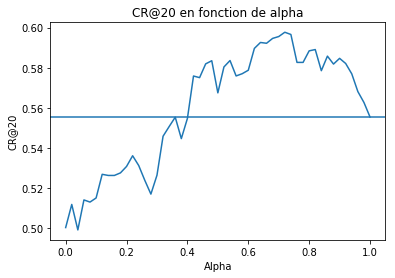

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.title("CR@20 en fonction de alpha")

alphas =  np.linspace(0., 1, 51)
plt.axhline(y=train_results['baseline']['cluster_recall_at_20'], label="Baseline")

#plt.plot(alphas, [train_results['{:.3f}'.format(alpha)]['cluster_recall_at_20'] for alpha in alphas])
plt.errorbar(alphas,
             [train_results['{:.3f}'.format(alpha)]['cluster_recall_at_20'] for alpha in alphas],
             #yerr=[train_results['{:.3f}'.format(alpha)]['cluster_recall_at_20_std'] for alpha in alphas],
             capsize=4)

plt.xlabel("Alpha")
plt.ylabel("CR@20")
#fig.savefig('diversite_glouton_recall.png', dpi=120)
plt.show()


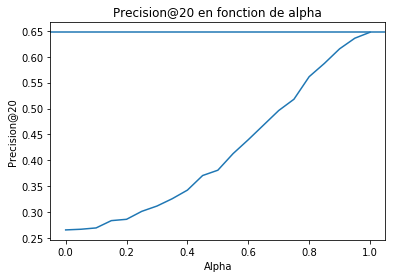

In [11]:
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)#, sharey=ax1)
plt.title("Precision@20 en fonction de alpha")
alphas =  np.linspace(0., 1, 21)
plt.axhline(y=train_results['baseline']['precision_at_20'], label="Baseline")

#plt.plot(alphas, [train_results['{:.3f}'.format(alpha)]['precision_at_20'] for alpha in alphas])
plt.errorbar(alphas,
             [train_results['{:.3f}'.format(alpha)]['precision_at_20'] for alpha in alphas],
             #yerr=[train_results['{:.3f}'.format(alpha)]['precision_at_20_std'] for alpha in alphas],
             capsize=4)
plt.xlabel("Alpha")
plt.ylabel("Precision@20")
fig.savefig('diversite_glouton_precision.png', dpi=120)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

'''  
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
plt.title('CR@20 en test en fonction de alpha')
ax2.errorbar(range(6), test_results[str(alpha)]['cluster_recall_at_20'], yerr=test_results[str(alpha)]['cluster_recall_at_20_std'], capsize=4)

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
plt.title('Precision@20 en test en fonction de alpha')
ax2.errorbar(range(20), test_results[str(alpha)]['precision_at_20'], yerr=test_results[str(alpha)]['precision_at_20_std'], capsize=4)
'''
plt.show()